In [2]:
import contextlib
import logging
import os
import random
import string
import subprocess
from collections import Counter

import numpy as np
from rdkit import Chem
from rdkit import RDConfig
from rdkit import rdBase
from rdkit.Chem import AllChem
from rdkit.Chem import BRICS
from rdkit.Chem import ChemicalFeatures
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem.rdchem import BondType as BT
from rdkit.Chem.rdchem import HybridizationType

rdBase.DisableLog('rdApp.error')

import pandas as pd
from rdkit import DataStructs

import torch
from torch_geometric.data import (Data)
from torch_sparse import coalesce

atomic_numbers = {"H": 1, "He": 2, "Li": 3, "Be": 4, "B": 5, "C": 6, "N": 7, "O": 8, "F": 9, "Ne": 10, "Na": 11, "Mg": 12, "Al": 13, "Si": 14,
                  "P": 15, "S": 16, "Cl": 17, "Ar": 18, "K": 19, "Ca": 20, "Sc": 21, "Ti": 22, "V": 23, "Cr": 24, "Mn": 25, "Fe": 26, "Co": 27,
                  "Ni": 28, "Cu": 29, "Zn": 30, "Ga": 31, "Ge": 32, "As": 33, "Se": 34, "Br": 35, "Kr": 36, "Rb": 37, "Sr": 38, "Y": 39,
                  "Zr": 40, "Nb": 41, "Mo": 42, "Tc": 43, "Ru": 44, "Rh": 45, "Pd": 46, "Ag": 47, "Cd": 48, "In": 49, "Sn": 50, "Sb": 51,
                  "Te": 52, "I": 53, "Xe": 54, "Cs": 55, "Ba": 56}


def onehot(arr, num_classes, dtype=np.int32):
    arr = np.asarray(arr, dtype=np.int32)
    assert len(arr.shape) ==1, "dims other than 1 not implemented"
    onehot_arr = np.zeros(arr.shape + (num_classes,), dtype=dtype)
    onehot_arr[np.arange(arr.shape[0]), arr] = 1
    return onehot_arr

# def mol_from_frag(jun_bonds, frags=None, frag_smis=None, coord=None, optimize=False):
#     "joins 2 or more fragments into a single molecule"
#     jun_bonds = np.asarray(jun_bonds)
#     #if jun_bonds.shape[0] == 0: jun_bonds = np.empty([0,4])
#     if frags is not None:
#         pass
#     elif frags is None and frag_smis is not None:
#         frags = [Chem.MolFromSmiles(frag_name) for frag_name in frag_smis]
#     else:
#         raise ValueError("invalid argument either frags or frags smis should be not None")
#     if len(frags) == 0: return None, None
#     nfrags = len(frags)
#     # combine fragments into a single molecule
#     mol = frags[0]
#     for i in np.arange(nfrags-1)+1:
#         mol = Chem.CombineMols(mol, frags[i])
#     # add junction bonds between fragments
#     frag_startidx = np.concatenate([[0], np.cumsum([frag.GetNumAtoms() for frag in frags])], 0)[:-1]

#     if jun_bonds.size == 0:
#         mol_bonds = []
#     else:
#         mol_bonds = frag_startidx[jun_bonds[:, 0:2]] + jun_bonds[:, 2:4]

#     emol = Chem.EditableMol(mol)

#     [emol.AddBond(int(bond[0]), int(bond[1]), Chem.BondType.SINGLE) for bond in mol_bonds]
#     mol = emol.GetMol()
#     atoms = list(mol.GetAtoms())

#     def _pop_H(atom):
#         nh = atom.GetNumExplicitHs()
#         if nh > 0: atom.SetNumExplicitHs(nh-1)

#     [(_pop_H(atoms[bond[0]]), _pop_H(atoms[bond[1]])) for bond in mol_bonds]
#     #print([(atom.GetNumImplicitHs(), atom.GetNumExplicitHs(),i) for i,atom in enumerate(mol.GetAtoms())])
#     Chem.SanitizeMol(mol)
#     # create and optimize 3D structure
#     if optimize:
#         assert not "h" in set([atm.GetSymbol().lower() for atm in mol.GetAtoms()]), "can't optimize molecule with h"
#         Chem.AddHs(mol)
#         AllChem.EmbedMolecule(mol)
#         AllChem.MMFFOptimizeMolecule(mol)
#         Chem.RemoveHs(mol)
#     return mol, mol_bonds

from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np

from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np

def mol_from_frag(jun_bonds, frags=None, frag_smis=None, coord=None, optimize=False):
    """
    Join multiple fragments into a single molecule by connecting dummy atoms [*:k].
    Each connection removes exactly the two dummy atoms involved.
    jun_bonds: list of [frag1_id, frag2_id, k1, k2, (optional) bond_type]
    """
    print(jun_bonds,frags,frag_smis)
    jun_bonds = np.asarray(jun_bonds, dtype=object)

    # ① 载入片段
    if frags is None and frag_smis is not None:
        frags = [Chem.MolFromSmiles(smi) for smi in frag_smis]
    if len(frags) == 0:
        return None, None
    nfrags = len(frags)

    # ② 合并所有fragment
    mol = frags[0]
    for i in range(1, nfrags):
        mol = Chem.CombineMols(mol, frags[i])

    frag_startidx = np.concatenate([[0], np.cumsum([f.GetNumAtoms() for f in frags])], 0)[:-1]

    # ③ 建立 [*:k] 编号 → 局部 atom index 映射
    frag_maps = []
    for frag in frags:
        amap = {}
        for atom in frag.GetAtoms():
            if atom.GetSymbol() == '*' and atom.HasProp('molAtomMapNumber'):
                amap[int(atom.GetProp('molAtomMapNumber'))] = atom.GetIdx()
        frag_maps.append(amap)

    # ④ 处理连接
    mol_bonds = []
    dummy_to_remove = []
    for jb in jun_bonds:
        if len(jb) == 4:
            f1, f2, k1, k2 = jb
            bond_type = Chem.BondType.SINGLE
        elif len(jb) == 5:
            assert 0 and "this is not defined jb==5"
            f1, f2, k1, k2, btype = jb
            bond_type = getattr(Chem.BondType, btype.upper())
        else:
            raise ValueError("jun_bonds entries must be [f1,f2,k1,k2,(optional)bond_type]")

        idx1 = int(frag_startidx[f1] + frag_maps[f1][int(k1)])
        idx2 = int(frag_startidx[f2] + frag_maps[f2][int(k2)])
        mol_bonds.append((idx1, idx2, bond_type))
        dummy_to_remove.extend([idx1, idx2])

    # ⑤ 添加键
    # emol = Chem.EditableMol(mol)
    # for a1, a2, bond_type in mol_bonds:
    #     emol.AddBond(int(a1), int(a2), bond_type)
    # mol = emol.GetMol()
    # ⑥ 删除参与连接的 dummy 原子
    emol = Chem.EditableMol(mol)
    nbrs_lst, remove_lst = [], []
    for idx in sorted(dummy_to_remove, reverse=True):
        idx = int(idx)
        atom = mol.GetAtomWithIdx(idx)
        nbrs = [n.GetIdx() for n in atom.GetNeighbors()]
        nbrs_lst.extend(nbrs)
        # print('nbrs num is:',nbrs,idx)
        # if len(nbrs) == 2:
        #     # 检查是否已有键，避免重复
        #     if not mol.GetBondBetweenAtoms(nbrs[0], nbrs[1]):
        #         emol.AddBond(int(nbrs[0]), int(nbrs[1]), Chem.BondType.SINGLE)
        # emol.RemoveAtom(idx)
        remove_lst.append(idx)
    print(nbrs_lst)
    assert len(nbrs_lst)==2
    emol.AddBond(int(nbrs_lst[0]), int(nbrs_lst[1]), bond_type)
    for idx in remove_lst:
        emol.RemoveAtom(idx)
        
    mol = emol.GetMol()

    # ⑦ 清理与优化
    Chem.SanitizeMol(mol)
    if optimize:
        Chem.AddHs(mol)
        AllChem.EmbedMolecule(mol)
        AllChem.MMFFOptimizeMolecule(mol)
        Chem.RemoveHs(mol)

    return mol, mol_bonds



class FPEmbedding_v2:
    def __init__(self, mol_fp_len, mol_fp_radiis, stem_fp_len, stem_fp_radiis):
        self.mol_fp_len = mol_fp_len
        self.mol_fp_radiis = mol_fp_radiis
        self.stem_fp_len = stem_fp_len
        self.stem_fp_radiis = stem_fp_radiis

    def __call__(self, molecule):
        mol = molecule.mol
        mol_fp = get_fp(mol, self.mol_fp_len, self.mol_fp_radiis)

        # get fingerprints and also handle empty case
        stem_fps = [get_fp(mol, self.stem_fp_len, self.stem_fp_radiis, [idx])
                    for idx in molecule.stem_atmidxs]

        jbond_fps = [(get_fp(mol, self.stem_fp_len, self.stem_fp_radiis, [idx[0]]) +
                     get_fp(mol, self.stem_fp_len, self.stem_fp_radiis, [idx[1]]))/2.
                     for idx in molecule.jbond_atmidxs]

        if len(stem_fps) > 0:
            stem_fps = np.stack(stem_fps, 0)
        else:
            stem_fps = np.empty(shape=[0, self.stem_fp_len * len(self.stem_fp_radiis)], dtype=np.float32)
        if len(jbond_fps) > 0:
            jbond_fps = np.stack(jbond_fps, 0)
        else:
            jbond_fps = np.empty(shape=[0, self.stem_fp_len * len(self.stem_fp_radiis)], dtype=np.float32)
        return mol_fp, stem_fps, jbond_fps



_mpnn_feat_cache = [None]


def mpnn_feat(mol, ifcoord=True, panda_fmt=False, one_hot_atom=False, donor_features=False):
    atomtypes = {'H': 0, 'C': 1, 'N': 2, 'O': 3, 'F': 4}
    bondtypes = {BT.SINGLE: 0, BT.DOUBLE: 1, BT.TRIPLE: 2, BT.AROMATIC: 3}

    natm = len(mol.GetAtoms())
    ntypes = len(atomtypes)
    # featurize elements
    # columns are: ["type_idx" .. , "atomic_number", "acceptor", "donor",
    # "aromatic", "sp", "sp2", "sp3", "num_hs", [atomic_number_onehot] .. ])

    nfeat = ntypes + 1 + 8
    if one_hot_atom:
        nfeat += len(atomic_numbers)
    atmfeat = np.zeros((natm, nfeat))

    # featurize
    for i, atom in enumerate(mol.GetAtoms()):
        type_idx = atomtypes.get(atom.GetSymbol(), 5)
        atmfeat[i, type_idx] = 1
        if one_hot_atom:
            atmfeat[i, ntypes + 9 + atom.GetAtomicNum() - 1] = 1
        else:
            atmfeat[i, ntypes + 1] = (atom.GetAtomicNum() % 16) / 2.
        atmfeat[i, ntypes + 4] = atom.GetIsAromatic()
        hybridization = atom.GetHybridization()
        atmfeat[i, ntypes + 5] = hybridization == HybridizationType.SP
        atmfeat[i, ntypes + 6] = hybridization == HybridizationType.SP2
        atmfeat[i, ntypes + 7] = hybridization == HybridizationType.SP3
        atmfeat[i, ntypes + 8] = atom.GetTotalNumHs(includeNeighbors=True)

    # get donors and acceptors
    if donor_features:
        if _mpnn_feat_cache[0] is None:
            fdef_name = os.path.join(RDConfig.RDDataDir, 'BaseFeatures.fdef')
            factory = ChemicalFeatures.BuildFeatureFactory(fdef_name)
            _mpnn_feat_cache[0] = factory
        else:
            factory = _mpnn_feat_cache[0]
        feats = factory.GetFeaturesForMol(mol)
        for j in range(0, len(feats)):
             if feats[j].GetFamily() == 'Donor':
                 node_list = feats[j].GetAtomIds()
                 for k in node_list:
                     atmfeat[k, ntypes + 3] = 1
             elif feats[j].GetFamily() == 'Acceptor':
                 node_list = feats[j].GetAtomIds()
                 for k in node_list:
                     atmfeat[k, ntypes + 2] = 1
    # get coord
    if ifcoord:
        coord = np.asarray([mol.GetConformer(0).GetAtomPosition(j) for j in range(natm)])
    else:
        coord = None
    # get bonds and bond features
    bond = np.asarray([[bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()] for bond in mol.GetBonds()])
    bondfeat = [bondtypes[bond.GetBondType()] for bond in mol.GetBonds()]
    bondfeat = onehot(bondfeat, num_classes=len(bondtypes))

    # convert atmfeat to pandas
    if panda_fmt:
        atmfeat_pd = pd.DataFrame(index=range(natm), columns=[
            "type_idx", "atomic_number", "acceptor", "donor", "aromatic", "sp", "sp2", "sp3", "num_hs"])
        atmfeat_pd['type_idx'] = atmfeat[:, :ntypes+1]
        atmfeat_pd['atomic_number'] = atmfeat[:, ntypes+1]
        atmfeat_pd['acceptor'] = atmfeat[:, ntypes+2]
        atmfeat_pd['donor'] = atmfeat[:, ntypes+3]
        atmfeat_pd['aromatic'] = atmfeat[:, ntypes+4]
        atmfeat_pd['sp'] = atmfeat[:, ntypes+5]
        atmfeat_pd['sp2'] = atmfeat[:, ntypes+6]
        atmfeat_pd['sp2'] = atmfeat[:, ntypes+7]
        atmfeat_pd['sp3'] = atmfeat[:, ntypes+8]
        atmfeat = atmfeat_pd
    return atmfeat, coord, bond, bondfeat


def mol_to_graph_backend(atmfeat, coord, bond, bondfeat, props={}, data_cls=Data):
    "convert to PyTorch geometric module"
    natm = atmfeat.shape[0]
    # transform to torch_geometric bond format; send edges both ways; sort bonds
    atmfeat = torch.tensor(atmfeat, dtype=torch.float32)
    if bond.shape[0] > 0:
        edge_index = torch.tensor(np.concatenate([bond.T, np.flipud(bond.T)], axis=1), dtype=torch.int64)
        edge_attr = torch.tensor(np.concatenate([bondfeat, bondfeat], axis=0), dtype=torch.float32)
        edge_index, edge_attr = coalesce(edge_index, edge_attr, natm, natm)
    else:
        edge_index = torch.zeros((0, 2), dtype=torch.int64)
        edge_attr = torch.tensor(bondfeat, dtype=torch.float32)

    # make torch data
    if coord is not None:
        coord = torch.tensor(coord, dtype=torch.float32)
        data = data_cls(x=atmfeat, pos=coord, edge_index=edge_index, edge_attr=edge_attr, **props)
    else:
        data = data_cls(x=atmfeat, edge_index=edge_index, edge_attr=edge_attr, **props)
    return data

class GenMolFile:
    def __init__(self, outpath, mgltools, mglbin):
        self.outpath = outpath
        self.prepare_ligand4 = os.path.join(mgltools, "AutoDockTools/Utilities24/prepare_ligand4.py")
        self.mglbin = mglbin

        os.makedirs(os.path.join(outpath, "sdf"), exist_ok=True)
        os.makedirs(os.path.join(outpath, "mol2"), exist_ok=True)
        os.makedirs(os.path.join(outpath, "pdbqt"), exist_ok=True)

    def __call__(self, smi, mol_name, num_conf):
        sdf_file = os.path.join(self.outpath, "sdf", f"{mol_name}.sdf")
        mol2_file = os.path.join(self.outpath, "mol2", f"{mol_name}.mol2")
        pdbqt_file = os.path.join(self.outpath, "pdbqt", f"{mol_name}.pdbqt")

        mol = Chem.MolFromSmiles(smi)
        Chem.SanitizeMol(mol)
        mol_h = Chem.AddHs(mol)
        AllChem.EmbedMultipleConfs(mol_h, numConfs=num_conf)
        for i in range(num_conf):
            AllChem.MMFFOptimizeMolecule(mol_h, confId=i)
        mp = AllChem.MMFFGetMoleculeProperties(mol_h, mmffVariant='MMFF94')
        # choose minimum energy conformer
        mi = np.argmin([AllChem.MMFFGetMoleculeForceField(mol_h, mp, confId=i).CalcEnergy() for i in range(num_conf)])
        print(Chem.MolToMolBlock(mol_h, confId=int(mi)), file=open(sdf_file, 'w+'))
        os.system(f"obabel -isdf {sdf_file} -omol2 -O {mol2_file}")
        os.system(f"{self.mglbin}/pythonsh {self.prepare_ligand4} -l {mol2_file} -o {pdbqt_file}")
        return pdbqt_file


class DockVina_smi:
    def __init__(self,
                 outpath,
                 mgltools_dir=os.path.join("Programs", "mgltools_x86_64Linux2_1.5.6"),
                 vina_dir=os.path.join("Programs", "vina"),
                 docksetup_dir=os.path.join("data", "seh/4jnc"),
                 rec_file="4jnc.nohet.aligned.pdbqt",
                 bindsite=(-13.4, 26.3, -13.3, 20.013, 16.3, 18.5),
                 dock_pars="",
                 cleanup=True):

        self.outpath = outpath
        self.mgltools = os.path.join(mgltools_dir, "MGLToolsPckgs")
        self.mgltools_bin = os.path.join(mgltools_dir, "bin")
        self.vina_bin = os.path.join(vina_dir, "bin/vina")
        self.rec_file = os.path.join(docksetup_dir, rec_file)
        self.bindsite = bindsite
        self.dock_pars = dock_pars
        self.cleanup = cleanup

        self.gen_molfile = GenMolFile(self.outpath, self.mgltools, self.mgltools_bin)
        # make vina command
        self.dock_cmd = "{} --receptor {} " \
                        "--center_x {} --center_y {} --center_z {} " \
                        "--size_x {} --size_y {} --size_z {} "
        self.dock_cmd = self.dock_cmd.format(self.vina_bin, self.rec_file, *self.bindsite)
        self.dock_cmd += " --ligand {} --out {}"

        os.makedirs(os.path.join(self.outpath, "docked"), exist_ok=True)

    def dock(self, smi, mol_name=None, molgen_conf=20):
        mol_name = mol_name or ''.join(random.choices(string.ascii_uppercase + string.digits, k=15))
        docked_file = os.path.join(self.outpath, "docked", f"{mol_name}.pdb")
        input_file = self.gen_molfile(smi, mol_name, molgen_conf)
        # complete docking query
        dock_cmd = self.dock_cmd.format(input_file, docked_file)
        dock_cmd = dock_cmd + " " + self.dock_pars

        # dock
        cl = subprocess.Popen(dock_cmd, shell=True, stdout=subprocess.PIPE)
        cl.wait()
        # parse energy
        with open(docked_file) as f:
            docked_pdb = f.readlines()
        if docked_pdb[1].startswith("REMARK VINA RESULT"):
            dockscore = float(docked_pdb[1].split()[3])
        else:
            raise Exception("Can't parse docking energy")
        # parse coordinates
        # TODO: fix order
        coord = []
        endmodel_idx = 0
        for idx, line in enumerate(docked_pdb):
            if line.startswith("ENDMDL"):
                endmodel_idx = idx
                break

        docked_pdb_model_1 = docked_pdb[:endmodel_idx]  # take only the model corresponding to the best energy
        docked_pdb_model_1_atoms = [line for line in docked_pdb_model_1 if line.startswith("ATOM")
                                    and line.split()[2][0] != 'H']  # ignore hydrogen
        coord.append([line.split()[-7:-4] for line in docked_pdb_model_1_atoms])
        coord = np.array(coord, dtype=np.float32)

        if self.cleanup:
            with contextlib.suppress(FileNotFoundError):
                os.remove(os.path.join(self.outpath, "sdf", f"{mol_name}.sdf"))
                os.remove(os.path.join(self.outpath, "mol2", f"{mol_name}.mol2"))
                os.remove(os.path.join(self.outpath, "pdbqt", f"{mol_name}.pdbqt"))
                os.remove(os.path.join(self.outpath, "docked", f"{mol_name}.pdb"))
        return mol_name, dockscore, coord

from rdkit.Chem import Draw

if __name__ == '__main__':
    frag_smis = [
        "[*:1]C1C(C)CC(C)CC1C",
        "C1N([*:1])C([*:4])=C([*:3])N1[*:2]",
    ]
    jun_bonds = [
        [0, 1, 1, 2],  # 连接第0片段的[*:1] 与第1片段的[*:1]
    ]
    # mol = Chem.MolFromSmiles("C1N([*:1])C([*:4])=C([*:3])N1[*:2]")
    mol = Chem.MolFromSmiles("CC1CC(C)C(N2CN([*:1])C([*:4])=C2[*:3])C(C)C1")
    img = Draw.MolToImage(mol, size=(400, 400))
    img.save("mol_vis.png")
    print("分子结构已保存为 mol_vis.png")

    mol, bonds = mol_from_frag(jun_bonds, frag_smis=frag_smis)
    print(Chem.MolToSmiles(mol))


分子结构已保存为 mol_vis.png
[[0, 1, 1, 2]] None ['[*:1]C1C(C)CC(C)CC1C', 'C1N([*:1])C([*:4])=C([*:3])N1[*:2]']
[17, 1]
CC1CC(C)C(N2CN([*:1])C([*:4])=C2[*:3])C(C)C1


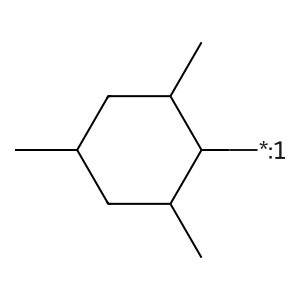

In [3]:
frag_smis = [
    "[*:1]C1C(C)CC(C)CC1C",
    "C1N([*:1])C([*:4])=C([*:3])N1[*:2]",
]
jun_bonds = [
    [0, 1, 1, 2],  # 连接第0片段的[*:1] 与第1片段的[*:1]
]
# mol = Chem.MolFromSmiles("C1N([*:1])C([*:4])=C([*:3])N1[*:2]")
# mol = Chem.MolFromSmiles("CC1CC(C)C(N2CN([*:1])C([*:4])=C2[*:3])C(C)C1")
mol = Chem.MolFromSmiles("[*:1]C1C(C)CC(C)CC1C")
Draw.MolToImage(mol)

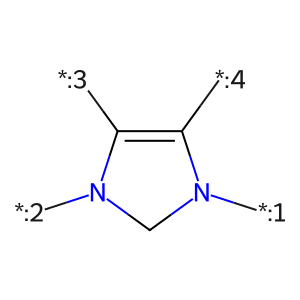

In [4]:
mol = Chem.MolFromSmiles("C1N([*:1])C([*:4])=C([*:3])N1[*:2]")
Draw.MolToImage(mol)

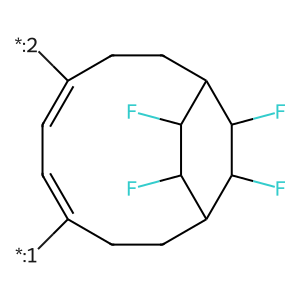

In [5]:
mol = Chem.MolFromSmiles("[*:1]C1=CC=C([*:2])CCC2C(F)C(F)C(CC1)C(F)C2F")
Draw.MolToImage(mol)